In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import pandas as pd
import numpy as np
import pathlib
from keras.applications.vgg16 import VGG16
from keras.preprocessing.image import ImageDataGenerator
from keras import models
from keras import layers
from keras import optimizers
from keras import metrics
from keras import backend as K
import matplotlib.pyplot as plt
import tensorflow as tf
import os

Using TensorFlow backend.


In [3]:
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
gpu_options = tf.GPUOptions(allow_growth=True)
sess = tf.Session(config=tf.ConfigProto(gpu_options=gpu_options))

In [4]:
conv_base = VGG16(weights='imagenet', 
                     include_top=False,
                     input_shape=(224, 224, 3))
conv_base.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

In [5]:
flat_layer = layers.Flatten()(conv_base.output)
dense_layer_1 = layers.Dense(256, activation='relu', kernel_initializer='he_normal')(flat_layer)
dropout_layer = layers.Dropout(0.5)(dense_layer_1)
dense_layer_2 = layers.Dense(38, activation='softmax', kernel_initializer='he_normal')(dropout_layer)
model = models.Model(inputs=conv_base.input, outputs=dense_layer_2)
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

In [6]:
def get_train_for_keras(input_csv):
    original_data = pd.read_csv(input_csv)
    df_train_for_keras = original_data.loc[original_data['is_valid'] == False, ['relative_path', 'label']]
    df_train_for_keras = df_train_for_keras.astype(str)
    return df_train_for_keras

def get_val_for_keras(input_csv):
    original_data = pd.read_csv(input_csv)
    df_val_for_keras = original_data.loc[original_data['is_valid'] == True, ['relative_path', 'label']]
    df_val_for_keras = df_val_for_keras.astype(str)
    return df_val_for_keras

df_train_for_keras = get_train_for_keras(str(pathlib.Path.cwd()) + "/temp/" + "train_val_group.csv")
print(df_train_for_keras[:5])

df_val_for_keras = get_val_for_keras(str(pathlib.Path.cwd()) + "/temp/" + "train_val_group.csv")
print(df_val_for_keras[:5])

directory = str(pathlib.Path.cwd()) + "/raw_datasets/images/plantVillage"

                                       relative_path label
0  Orange___Haunglongbing_(Citrus_greening)/UF.Ci...    15
1  Orange___Haunglongbing_(Citrus_greening)/CREC_...    15
2         Squash___Powdery_mildew/MD_Powd.M 1073.JPG    25
3  Cherry_(including_sour)___Powdery_mildew/FREC_...     5
4                   Soybean___healthy/RS_HL 5527.JPG    24
                                           relative_path label
38061  Orange___Haunglongbing_(Citrus_greening)/CREC_...    15
38062  Orange___Haunglongbing_(Citrus_greening)/CREC_...    15
38063  Cherry_(including_sour)___Powdery_mildew/FREC_...     5
38064           Tomato___Late_blight/GHLB2 Leaf 9017.JPG    30
38065                 Grape___healthy/Mt.N.V_HL 6114.JPG    14


In [7]:
train_datagen = ImageDataGenerator(featurewise_center=True,
                                   featurewise_std_normalization=True,
                                   rescale=1./255,
                                   rotation_range=25,
                                   horizontal_flip=True)
val_datagen = ImageDataGenerator(rescale=1./255)

In [8]:
train_generator = train_datagen.flow_from_dataframe(df_train_for_keras,
                                                    directory=directory,
                                                    x_col='relative_path',
                                                    y_col='label',
                                                    target_size=(224, 224),
                                                    batch_size=64,
                                                    drop_duplicates=False)
val_generator = val_datagen.flow_from_dataframe(df_val_for_keras,
                                                directory=directory,
                                                x_col='relative_path',
                                                y_col='label',
                                                target_size=(224, 224),
                                                batch_size=64,
                                                shuffle=False,
                                                drop_duplicates=False)

Found 38061 images belonging to 38 classes.
Found 5274 images belonging to 38 classes.


In [9]:
conv_base.trainable = False

In [10]:
opt = optimizers.SGD(lr=0.005, momentum=0.9, decay=0.0005)

model.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=[metrics.categorical_accuracy])

history = model.fit_generator(train_generator,
                              steps_per_epoch=595,
                              epochs=10,
                              validation_data=val_generator,
                              validation_steps=83)

model.save(str(pathlib.Path.cwd()) + "/models/" + "vgg16_keras_stage_1_group.h5")

Epoch 1/10
595/595 [==============================] - 489s 822ms/step - loss: 2.6795 - categorical_accuracy: 0.2957 - val_loss: 1.1299 - val_categorical_accuracy: 0.6570
Epoch 2/10
595/595 [==============================] - 481s 809ms/step - loss: 0.8498 - categorical_accuracy: 0.7392 - val_loss: 0.3250 - val_categorical_accuracy: 0.8936
Epoch 3/10
595/595 [==============================] - 479s 805ms/step - loss: 0.3515 - categorical_accuracy: 0.8859 - val_loss: 0.1916 - val_categorical_accuracy: 0.9334
Epoch 4/10
595/595 [==============================] - 479s 806ms/step - loss: 0.2164 - categorical_accuracy: 0.9303 - val_loss: 0.1808 - val_categorical_accuracy: 0.9416
Epoch 5/10
595/595 [==============================] - 482s 810ms/step - loss: 0.1483 - categorical_accuracy: 0.9527 - val_loss: 0.1005 - val_categorical_accuracy: 0.9664
Epoch 6/10
595/595 [==============================] - 485s 816ms/step - loss: 0.1143 - categorical_accuracy: 0.9628 - val_loss: 0.1190 - val_categoric

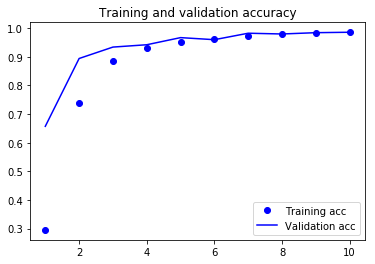

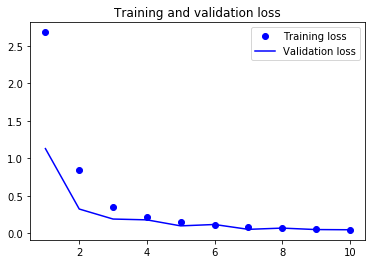

In [11]:
acc = history.history['categorical_accuracy']
val_acc = history.history['val_categorical_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [11]:
K.clear_session()
#for each_layer in model.layers[:15]:
#    each_layer.trainable = False
    
#for each_layer in model.layers[15:]:
#    each_layer.trainable = True

In [17]:
model = models.load_model(str(pathlib.Path.cwd()) + "/models/" + "vgg16_keras_stage_1_group.h5")
model.trainable = True

opt = optimizers.SGD(lr=0.0005, momentum=0.9, decay=0.0005)

model.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=[metrics.categorical_accuracy])

history = model.fit_generator(train_generator,
                              steps_per_epoch=595,
                              epochs=10,
                              validation_data=val_generator,
                              validation_steps=83)

model.save(str(pathlib.Path.cwd()) + "/models/" + "vgg16_keras_stage_2_group.h5")

Epoch 1/10
595/595 [==============================] - 474s 797ms/step - loss: 0.0165 - categorical_accuracy: 0.9950 - val_loss: 0.0299 - val_categorical_accuracy: 0.9898
Epoch 2/10
595/595 [==============================] - 466s 783ms/step - loss: 0.0151 - categorical_accuracy: 0.9953 - val_loss: 0.0281 - val_categorical_accuracy: 0.9909
Epoch 3/10
595/595 [==============================] - 466s 782ms/step - loss: 0.0117 - categorical_accuracy: 0.9959 - val_loss: 0.0318 - val_categorical_accuracy: 0.9896
Epoch 4/10
595/595 [==============================] - 467s 785ms/step - loss: 0.0116 - categorical_accuracy: 0.9964 - val_loss: 0.0293 - val_categorical_accuracy: 0.9907
Epoch 5/10
595/595 [==============================] - 466s 783ms/step - loss: 0.0105 - categorical_accuracy: 0.9964 - val_loss: 0.0276 - val_categorical_accuracy: 0.9911
Epoch 6/10
595/595 [==============================] - 468s 787ms/step - loss: 0.0111 - categorical_accuracy: 0.9966 - val_loss: 0.0259 - val_categoric

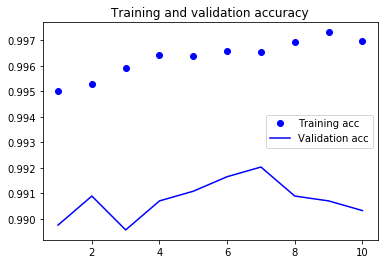

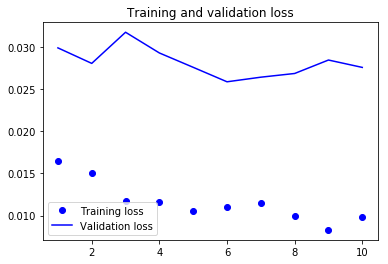

In [18]:
acc = history.history['categorical_accuracy']
val_acc = history.history['val_categorical_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()